In [61]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import product
import re       

In [ ]:
"""
Make a helper function that extracts the n-th number from a string
"""
def extract_nth_number(s, n):
    numbers = re.findall(r'\d+', s)
    if 0 < n <= len(numbers):
        return int(numbers[n - 1])
    else:
        return None

In [62]:
""" 
Import all report cards

"""

# Path to the report cards
bids_root = str(Path.home()) + '/Documents/muniverse-data/report_cards/'

# List of datasetnames
datasetnames = ['Caillet_et_al_2023', 'Grison_et_al_2025', 'Avrillon_et_al_2024', 'hybrid_tibialis', 'neuromotion_test']

# List of algorithm names
pipelinenames = ['cbss', 'scd']
#pipelinenames = ['cbss', 'scd', 'upperbound']

# Make an empty template of a report card dictonary
global_rc = {pipeline: pd.DataFrame() for pipeline in pipelinenames}
source_rc = {pipeline: pd.DataFrame() for pipeline in pipelinenames}

# Read in report cards
for dataset in datasetnames:
    for pipeline in pipelinenames:
        path = bids_root + dataset + '-' + pipeline + '/'
        dataset_global_rc = pd.read_csv(path + 'report_card_globals.tsv', delimiter='\t')
        dataset_source_rc = pd.read_csv(path + 'report_card_sources.tsv', delimiter='\t')
        global_rc[pipeline] = pd.concat([global_rc[pipeline], dataset_global_rc], ignore_index=True)
        source_rc[pipeline] = pd.concat([source_rc[pipeline], dataset_source_rc], ignore_index=True)

In [63]:
""" 
Extract some global metrics from some dataset of interest

"""

dataset_of_interest = ['hybrid-tibialis', 'neuromotion-test']
#dataset_of_interest = ['neuromotion-test']
#dataset_of_interest = ['Caillet_et_al_2023', 'Grison_et_al_2025', 'Avrillon_et_al_2024']
#dataset_of_interest = ['Caillet_et_al_2023', 'Grison_et_al_2025', 'hybrid-tibialis', 'neuromotion-test']

task_keys = ['isometric', 'trapezoid']

rows = [f"{d}-{a}" for d, a in product(dataset_of_interest, pipelinenames)]
columns = ['n_source_10', 'n_source_50', 'n_source_90', 
           'exp_var_10', 'exp_var_50', 'exp_var_90',
           'runtime_10', 'runtime_50', 'runtime_90']
summary = pd.DataFrame(np.nan, index=rows, columns=columns) 

sil_th = 0.85
min_num_spikes = 30
mvc_threshold = 30

for dataset in dataset_of_interest:
    for pipeline in pipelinenames:
        # Get a unqiue identifier, i.e., dataset-pipeline
        row = f"{dataset}-{pipeline}"
        
        # Make a copy of the global data frame
        gdf = global_rc[pipeline].copy()
        # Only keep entries belonging to the current dataset
        gdf = gdf[(gdf['datasetname'] == dataset)]
        # Make sure the explained variance is in [0 1]
        gdf['explained_var'] = gdf['explained_var'].clip(lower=0, upper=1)
        # Focus on specific tasks and mvc level
        for task_key in task_keys:
            gdf = gdf[gdf['filename'].str.contains(task_key, case=False, na=False)]
        # Extract the MVC level from the file name and filter by intensity
        if dataset=='neuromotion-test':
            mvc_num = 3
        else:
            mvc_num = 2
        gdf['mvc'] = gdf['filename'].apply(lambda x: extract_nth_number(x, mvc_num))    
        gdf = gdf[(gdf['mvc'] < mvc_threshold)]
        
        # Make a copy of the source report card
        sdf = source_rc[pipeline].copy()
        # Only keep entries belonging to the current dataset
        sdf = sdf[(sdf['datasetname'] == dataset)]
        # Focus on specific tasks and mvc level
        for task_key in task_keys:
            sdf = sdf[sdf['filename'].str.contains(task_key, case=False, na=False)]
        # Extract the MVC level from the file name and filter by intensity
        sdf['mvc'] = sdf['filename'].apply(lambda x: extract_nth_number(x, mvc_num))    
        sdf = sdf[(sdf['mvc'] < mvc_threshold)]

        # List all filenames that are left to analyze and loop around them   
        files = list(gdf['filename'])
        n_sources = np.zeros(len(files))
        for idx, file in enumerate(files):
            # Make a copy of your source datafile 
            ssdf = sdf.copy()
            # Only keep sources that belong to the current file and fullfile some quality checks
            ssdf = sdf[(sdf['filename'] == file) & 
                       (sdf['sil'] > sil_th) & 
                       (sdf['n_spikes'] > min_num_spikes)]
            n_sources[idx] = ssdf.shape[0]

        # Get the 10th, 50th and 90th percentile of the number of extracted sources
        summary.loc[row, 'n_source_50'] = np.round(np.percentile(n_sources,50) ,2)
        summary.loc[row, 'n_source_10'] = np.round(np.percentile(n_sources,10), 2)
        summary.loc[row, 'n_source_90'] = np.round(np.percentile(n_sources,90), 2)   
        # Get the 10th, 50th and 90th percentile of the runtimes
        summary.loc[row, 'runtime_50'] = np.round(np.percentile(gdf['runtime'],50), 0)
        summary.loc[row, 'runtime_10'] = np.round(np.percentile(gdf['runtime'],10), 0)
        summary.loc[row, 'runtime_90'] = np.round(np.percentile(gdf['runtime'],90), 0)
        # Get the 10th, 50th and 90th percentile of the explained variance
        summary.loc[row, 'exp_var_50'] = np.round(np.percentile(gdf['explained_var'],50), 2)
        summary.loc[row, 'exp_var_10'] = np.round(np.percentile(gdf['explained_var'],10), 2)
        summary.loc[row, 'exp_var_90'] = np.round(np.percentile(gdf['explained_var'],90), 2) 

print(summary)          


                       n_source_10  n_source_50  n_source_90  exp_var_10  \
hybrid-tibialis-cbss           0.0          0.0          0.0        0.00   
hybrid-tibialis-scd            0.0          6.0         21.2        0.00   
neuromotion-test-cbss          5.0         13.0         25.0        0.20   
neuromotion-test-scd           1.0          6.0         18.3        0.04   

                       exp_var_50  exp_var_90  runtime_10  runtime_50  \
hybrid-tibialis-cbss         0.00        0.00         7.0        11.0   
hybrid-tibialis-scd          0.12        0.42       107.0       217.0   
neuromotion-test-cbss        0.46        0.63       260.0       430.0   
neuromotion-test-scd         0.27        0.58       117.0       218.0   

                       runtime_90  
hybrid-tibialis-cbss        624.0  
hybrid-tibialis-scd         581.0  
neuromotion-test-cbss       813.0  
neuromotion-test-scd        569.0  


In [ ]:
"""
Do spike matching for some dataset of interest

"""

# Dataset of interest
dataset_of_interest = ['Grison_et_al_2025']
# Pipelines to be analyzed
pipelinenames = ['cbss', 'scd']

# Make an empty data frame
rows = [f"{d}-{a}" for d, a in product(dataset_of_interest, pipelinenames)]
columns = ['n_source', 'n_rel', 
           'roa_10', 'roa_50', 'roa_90', 
           'precision_10', 'precision_50', 'precision_90',
           'sensitivity_10', 'sensitivity_50', 'sensitivity_90',
           'F1_10', 'F1_50', 'F1_90' 
           ]
summary = pd.DataFrame(np.nan, index=rows, columns=columns) 

# Select specific tasks
task_keys = []
# Filter by mvc level
mvc_threshold = 50

for dataset in dataset_of_interest:
    for pipeline in pipelinenames:
        # Get a unqiue identifier, i.e., dataset-pipeline
        row = f"{dataset}-{pipeline}"
        
        # Make a copy of the global data frame
        gdf = global_rc[pipeline].copy()
        # Only keep entries belonging to the current dataset
        gdf = gdf[(gdf['datasetname'] == dataset)]
        # Make sure the explained variance is in [0 1]
        gdf['explained_var'] = gdf['explained_var'].clip(lower=0, upper=1)
        # Focus on specific tasks and mvc level
        for task_key in task_keys:
            gdf = gdf[gdf['filename'].str.contains(task_key, case=False, na=False)]
        # Extract the MVC level from the file name and filter by intensity
        if dataset=='neuromotion-test':
            mvc_num = 3
        else:
            mvc_num = 2
        gdf['mvc'] = gdf['filename'].apply(lambda x: extract_nth_number(x, mvc_num))    
        gdf = gdf[(gdf['mvc'] < mvc_threshold)]

        # Make a copy of the source report card
        sdf = source_rc[pipeline].copy()
        # Only keep entries belonging to the current dataset
        sdf = sdf[(sdf['datasetname'] == dataset)]
        # Focus on specific tasks and mvc level
        for task_key in task_keys:
            sdf = sdf[sdf['filename'].str.contains(task_key, case=False, na=False)]
        # Extract the MVC level from the file name and filter by intensity
        sdf['mvc'] = sdf['filename'].apply(lambda x: extract_nth_number(x, mvc_num))    
        sdf = sdf[(sdf['mvc'] < mvc_threshold)]
        
        # Get the total number of sources
        n_total = int(sdf.shape[0])
        # Get the number of matched sources
        sdf = sdf[(sdf['TP'] > 1)]
        # Compute the rate of agreement
        sdf['RoA'] = sdf['TP'] / (sdf['TP'] + sdf['FP'] + sdf['FN'])
        # Compute the precision
        sdf['Precision'] = sdf['TP'] / (sdf['TP'] + sdf['FP'])
        # Compute the recall
        sdf['Recall'] = sdf['TP'] / (sdf['TP'] + sdf['FN'])
        # Calculate the F1 score
        sdf['F1'] = 2*sdf['Precision']*sdf['Recall']/ (sdf['Precision'] + sdf['Recall'])

        # Get both total and relative number of matched sources
        summary.loc[row, 'n_source'] = int(sdf.shape[0])
        if n_total > 0:
            summary.loc[row, 'n_rel'] = int(sdf.shape[0]) / n_total 
        else:
            summary.loc[row, 'n_rel'] = 0
        # Get the 10th, 50th and 90th percentile of the RoA
        summary.loc[row, 'roa_10'] = np.round(np.percentile(sdf['RoA'],10),2)
        summary.loc[row, 'roa_50'] = np.round(np.percentile(sdf['RoA'],50),2)
        summary.loc[row, 'roa_90'] = np.round(np.percentile(sdf['RoA'],90),2)
        # Get the 10th, 50th and 90th percentile of the Precision
        summary.loc[row, 'precision_10'] = np.round(np.percentile(sdf['Precision'],10),2)
        summary.loc[row, 'precision_50'] = np.round(np.percentile(sdf['Precision'],50),2)
        summary.loc[row, 'precision_90'] = np.round(np.percentile(sdf['Precision'],90),2)
        # Get the 10th, 50th and 90th percentile of the Recall
        summary.loc[row, 'sensitivity_10'] = np.round(np.percentile(sdf['Recall'],10),2)
        summary.loc[row, 'sensitivity_50'] = np.round(np.percentile(sdf['Recall'],50),2)
        summary.loc[row, 'sensitivity_90'] = np.round(np.percentile(sdf['Recall'],90),2)
        # Get the 10th, 50th and 90th percentile of the F1 score
        summary.loc[row, 'F1_10'] = np.round(np.percentile(sdf['F1'], 10),2)
        summary.loc[row, 'F1_50'] = np.round(np.percentile(sdf['F1'], 50),2)
        summary.loc[row, 'F1_90'] = np.round(np.percentile(sdf['F1'], 90),2) 



print(summary)          


                        n_source     n_rel  roa_10  roa_50  roa_90  \
Grison_et_al_2025-cbss      29.0  0.268519    0.63    0.86    0.96   
Grison_et_al_2025-scd       37.0  0.264286    0.24    0.84    0.97   

                        precision_10  precision_50  precision_90  \
Grison_et_al_2025-cbss          0.85          0.92          0.99   
Grison_et_al_2025-scd           0.84          0.92          0.99   

                        sensitivity_10  sensitivity_50  sensitivity_90  F1_10  \
Grison_et_al_2025-cbss            0.78            0.94            0.99   0.77   
Grison_et_al_2025-scd             0.24            0.93            0.99   0.39   

                        F1_50  F1_90  
Grison_et_al_2025-cbss   0.92   0.98  
Grison_et_al_2025-scd    0.91   0.99  


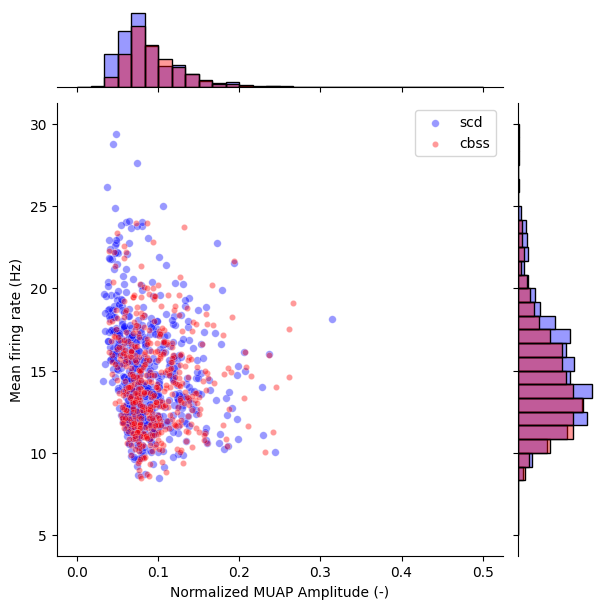

In [4]:
import seaborn as sns

sdf = source_rc['scd'].copy()

sdf = sdf[(sdf['sil'] > sil_th) & 
          (sdf['cov_isi'] < cov_th) &
          (sdf['n_spikes'] > min_num_spikes)]

x1 = np.asarray(sdf['muap_rms'])
y1 = np.asarray(sdf['mean_dr'])

sdf = source_rc['cbss'].copy()

sdf = sdf[(sdf['sil'] > sil_th) & 
          (sdf['cov_isi'] < cov_th) &
          (sdf['n_spikes'] > min_num_spikes)]

x2 = np.asarray(sdf['muap_rms'])
y2 = np.asarray(sdf['mean_dr'])

# Create a JointGrid
g = sns.JointGrid(x=x1, y=y1)

# Plot first dataset
g.plot_joint(sns.scatterplot, color="blue", label="scd",s=30, alpha=0.4)
sns.histplot(x=x1, color="blue", ax=g.ax_marg_x, alpha=0.4, bins=np.linspace(0,0.5,31))
sns.histplot(y=y1, color="blue", ax=g.ax_marg_y, alpha=0.4, bins=np.linspace(5,30,31))

# Overlay second dataset
sns.scatterplot(x=x2, y=y2, color="red", ax=g.ax_joint, label="cbss", s=20, alpha=0.4)
sns.histplot(x=x2, color="red", ax=g.ax_marg_x, alpha=0.4, bins=np.linspace(0,0.5,31))
sns.histplot(y=y2, color="red", ax=g.ax_marg_y, alpha=0.4, bins=np.linspace(5,30,31))

# Add legend
g.ax_joint.legend()
g.ax_joint.set_xlabel("Normalized MUAP Amplitude (-)")
g.ax_joint.set_ylabel("Mean firing rate (Hz)")

plt.show()